# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.




---
__Признаки__
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя


__Целевой признак__
- Price — цена (евро)


In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool
import lightgbm as lgb

## Подготовка данных

In [2]:
data = pd.read_csv('/datasets/autos.csv')

In [3]:
data.info()
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


Удалим дубликаты строк, заполним пропуски , скорректируем типы данных:

In [4]:
data = data.drop_duplicates().reset_index(drop=True)

data = data.fillna('null')

data = data.astype({'DateCrawled': 'datetime64[ns]',
                    'Price': 'int32',
                    'RegistrationYear': 'int16',
                    'Power': 'int16',
                    'Kilometer': 'int32',
                    'RegistrationMonth': 'int8',
                    'DateCreated': 'datetime64[ns]',
                    'NumberOfPictures': 'int32',
                    'PostalCode': 'int32',
                    'LastSeen': 'datetime64[ns]',
                     ###
                    'VehicleType':'category',
                    'Gearbox':'category',
                    'Model':'category',
                    'FuelType':'category',
                    'Brand':'category',
                    'NotRepaired':'category'                    
                   })
data.info()
data.describe().round(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 16 columns):
DateCrawled          354365 non-null datetime64[ns]
Price                354365 non-null int32
VehicleType          354365 non-null category
RegistrationYear     354365 non-null int16
Gearbox              354365 non-null category
Power                354365 non-null int16
Model                354365 non-null category
Kilometer            354365 non-null int32
RegistrationMonth    354365 non-null int8
FuelType             354365 non-null category
Brand                354365 non-null category
NotRepaired          354365 non-null category
DateCreated          354365 non-null datetime64[ns]
NumberOfPictures     354365 non-null int32
PostalCode           354365 non-null int32
LastSeen             354365 non-null datetime64[ns]
dtypes: category(6), datetime64[ns](3), int16(2), int32(4), int8(1)
memory usage: 17.6 MB


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354365.0,354365.0,354365.0,354365.0,354365.0,354365.0,354365.0
mean,4416.7,2004.2,110.1,128211.4,5.7,0.0,50508.5
std,4514.2,90.2,189.9,37905.1,3.7,0.0,25783.1
min,0.0,1000.0,0.0,5000.0,0.0,0.0,1067.0
25%,1050.0,1999.0,69.0,125000.0,3.0,0.0,30165.0
50%,2700.0,2003.0,105.0,150000.0,6.0,0.0,49413.0
75%,6400.0,2008.0,143.0,150000.0,9.0,0.0,71083.0
max,20000.0,9999.0,20000.0,150000.0,12.0,0.0,99998.0


In [5]:
data[['DateCrawled', 'DateCreated', 'LastSeen']].describe()

,DateCrawled,DateCreated,LastSeen
count,354365,354365,354365
unique,271174,109,179150
top,2016-03-24 14:49:47,2016-04-03 00:00:00,2016-04-06 13:45:54
freq,7,13718,17
first,2016-03-05 14:06:22,2014-03-10 00:00:00,2016-03-05 14:15:08
last,2016-04-07 14:36:58,2016-04-07 00:00:00,2016-04-07 14:58:51


Удалим данные не влияющие на цену:

In [6]:
data = data.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

In [7]:
display(data['VehicleType'].value_counts())

sedan          91457
small          79830
wagon          65165
null           37490
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: VehicleType, dtype: int64

In [8]:
data['Model'].value_counts()

golf                  29232
other                 24420
3er                   19761
null                  19705
polo                  13066
                      ...  
serie_2                   8
rangerover                4
serie_3                   4
range_rover_evoque        2
serie_1                   2
Name: Model, Length: 251, dtype: int64

In [9]:
sorted(data['Model'].unique())

['100',
 '145',
 '147',
 '156',
 '159',
 '1_reihe',
 '1er',
 '200',
 '2_reihe',
 '300c',
 '3_reihe',
 '3er',
 '4_reihe',
 '500',
 '5_reihe',
 '5er',
 '601',
 '6_reihe',
 '6er',
 '7er',
 '80',
 '850',
 '90',
 '900',
 '9000',
 '911',
 'a1',
 'a2',
 'a3',
 'a4',
 'a5',
 'a6',
 'a8',
 'a_klasse',
 'accord',
 'agila',
 'alhambra',
 'almera',
 'altea',
 'amarok',
 'antara',
 'arosa',
 'astra',
 'auris',
 'avensis',
 'aveo',
 'aygo',
 'b_klasse',
 'b_max',
 'beetle',
 'berlingo',
 'bora',
 'boxster',
 'bravo',
 'c1',
 'c2',
 'c3',
 'c4',
 'c5',
 'c_klasse',
 'c_max',
 'c_reihe',
 'caddy',
 'calibra',
 'captiva',
 'carisma',
 'carnival',
 'cayenne',
 'cc',
 'ceed',
 'charade',
 'cherokee',
 'citigo',
 'civic',
 'cl',
 'clio',
 'clk',
 'clubman',
 'colt',
 'combo',
 'cooper',
 'cordoba',
 'corolla',
 'corsa',
 'cr_reihe',
 'croma',
 'crossfire',
 'cuore',
 'cx_reihe',
 'defender',
 'delta',
 'discovery',
 'doblo',
 'ducato',
 'duster',
 'e_klasse',
 'elefantino',
 'eos',
 'escort',
 'espace',
 

In [10]:
data['FuelType'].value_counts()

petrol      216349
gasoline     98719
null         32895
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

In [11]:
data['Brand'].value_counts()

volkswagen        77012
opel              39931
bmw               36914
mercedes_benz     32044
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat               9643
seat               6907
mazda              5615
skoda              5500
smart              5246
citroen            5148
nissan             4941
toyota             4606
hyundai            3587
sonstige_autos     3374
volvo              3210
mini               3202
mitsubishi         3022
honda              2817
kia                2465
suzuki             2322
alfa_romeo         2314
chevrolet          1754
chrysler           1439
dacia               900
daihatsu            806
subaru              762
porsche             758
jeep                677
trabant             589
land_rover          545
daewoo              542
saab                526
jaguar              505
rover               486
lancia              471
lada                225
Name: Brand, dtype: int64

In [12]:
data['NotRepaired'].value_counts()

no      247158
null     71154
yes      36053
Name: NotRepaired, dtype: int64

Оставим объявления с ценой от 100 евро и выше:

In [13]:
data = data[data['Price']>=100].reset_index(drop=True)

мощностью более 30 л.с.:

In [14]:
data = data[data['Power']>30].reset_index(drop=True)

скорректируем неправдоподобные мощности (вероятнее всего была ошибка на 1 или 2 порядка):

In [15]:
data['Power'] = data['Power'].apply(lambda x: x if x<550 else x//10)
data['Power'] = data['Power'].apply(lambda x: x if x<550 else x//10)

оставим разумные годы регистрации (ретро автомобили вероятно оцениваются по другим критериям):

In [16]:
data = data[(data['RegistrationYear']>=1998)&
            (data['RegistrationYear']<=2018)].reset_index(drop=True)

Месяц регистрации содержит довольно много нулевых значений. Судя по распределению ноль означает, что месяц решистрации не был указан:

In [17]:
months = data[['RegistrationYear', 'RegistrationMonth']].copy()
months.columns = ['Год регистрации', 'Месяц Регистрации']
months['Количество объявлений:'] = 1
pd.pivot_table(months, index = 'Год регистрации', columns = 'Месяц Регистрации', aggfunc = 'sum' )

Количество объявлений:                                      \
Месяц Регистрации                     0     1     2     3     4     5     6    
Год регистрации                                                                
1998                                1361   876   827  1520  1103  1066  1336   
1999                                1509  1277  1172  2085  1618  1505  1684   
2000                                1792  1471  1181  1942  1442  1757  1544   
2001                                1103  1286  1135  1894  1453  1631  1565   
2002                                 805  1114  1418  1742  1457  1461  1601   
2003                                 788  1241  1109  2241  1484  1526  1664   
2004                                 594  1171  1071  1653  1845  1464  1626   
2005                                 904  1116  1093  1806  1522  1895  1819   
2006                                 511  1247  1105  1818  1613  1581  2116   
2007                                 338  1054   933  1668  1329  1402  1384   
2008                                 295  1084  1025  1385  1448  1228  1325   
2009                                 255   964  1069  1350  1262  1271  1414   
2010                                 109   701   714  1030   989   915  1010   
2011                                  85   765   723  1057   798   901   905   
2012                                  61   578   557   954   731   661   695   
2013                                  26   346   308   520   404   389   414   
2014                                  13   197   167   295   267   214   192   
2015                                  13   129   136   176   103    89   107   
2016                                1423   296   288   481   477   490   553   
2017                                1558   383   357   598   555   528   640   
2018                                 475   184   176   286   252   203   223   

                                                       
Месяц Регистрации    7     8     9     10    11    12  
Год регистрации                                        
1998               1232   976   990  1272  1194  1356  
1999               1649  1289  1409  1392  1385  1507  
2000               1256  1270  1167  1326  1244  1280  
2001               1415  1275  1282  1295  1253  1242  
2002               1412  1186  1168  1353  1279  1200  
2003               1346  1135  1345  1493  1238  1307  
2004               1421  1100  1309  1518  1518  1500  
2005               1471  1265  1555  1541  1350  1529  
2006               1402  1226  1332  1487  1547  1568  
2007               1586  1182  1254  1389  1242  1300  
2008               1159  1225  1109  1187  1006  1037  
2009               1121   990  1202  1147   980   798  
2010                756   701   770  1038   829   774  
2011                751   713   753   712   801   583  
2012                494   413   467   426   462   393  
2013                318   271   258   269   247   203  
2014                150   180   204   201   164   144  
2015                 74    60    45    54    43    30  
2016                426   390   356   432   368   328  
2017                534   437   392   462   445   469  
2018                170   157   173   168   198   196

Заменим нулевые значения случайными числами:

In [18]:
data['RegistrationMonth'] = data['RegistrationMonth'].apply(lambda x: np.random.randint(1,13) if x==0 else x)

In [19]:
months = data[['RegistrationYear', 'RegistrationMonth']].copy()
months.columns = ['Год регистрации', 'Месяц Регистрации']
months['Количество объявлений:'] = 1
pd.pivot_table(months, index = 'Год регистрации', columns = 'Месяц Регистрации', aggfunc = 'sum' )

Количество объявлений:                                      \
Месяц Регистрации                     1     2     3     4     5     6     7    
Год регистрации                                                                
1998                                 987   938  1639  1206  1188  1448  1346   
1999                                1401  1312  2196  1749  1624  1795  1768   
2000                                1642  1336  2095  1582  1923  1685  1397   
2001                                1376  1229  1985  1538  1729  1654  1493   
2002                                1182  1488  1807  1523  1521  1666  1492   
2003                                1306  1192  2301  1546  1592  1720  1417   
2004                                1233  1115  1696  1886  1513  1667  1469   
2005                                1194  1170  1895  1605  1967  1893  1549   
2006                                1294  1145  1859  1661  1630  2157  1438   
2007                                1079   961  1697  1361  1446  1405  1620   
2008                                1107  1050  1412  1476  1248  1353  1182   
2009                                 979  1087  1375  1284  1294  1433  1145   
2010                                 707   727  1043   995   923  1019   765   
2011                                 770   727  1062   805   913   913   759   
2012                                 589   562   958   734   664   699   499   
2013                                 348   312   523   408   392   415   320   
2014                                 199   169   295   269   215   193   150   
2015                                 130   137   177   103    90   108    74   
2016                                 420   385   598   598   623   666   535   
2017                                 501   485   741   699   654   762   668   
2018                                 234   213   328   286   242   268   210   

                                                 
Месяц Регистрации    8     9     10    11    12  
Год регистрации                                  
1998               1098  1082  1397  1311  1469  
1999               1425  1522  1531  1526  1632  
2000               1421  1316  1466  1377  1432  
2001               1366  1369  1392  1343  1355  
2002               1260  1230  1414  1350  1263  
2003               1201  1411  1558  1306  1367  
2004               1166  1360  1567  1556  1562  
2005               1335  1617  1623  1421  1597  
2006               1272  1373  1529  1588  1607  
2007               1211  1271  1421  1269  1320  
2008               1253  1130  1214  1025  1063  
2009               1015  1223  1173   996   819  
2010                710   781  1045   838   783  
2011                722   765   715   810   586  
2012                418   474   432   463   400  
2013                271   261   271   249   203  
2014                180   204   203   167   144  
2015                 62    47    54    44    33  
2016                512   465   569   491   446  
2017                563   516   596   572   601  
2018                194   201   206   239   240

## Обучение моделей

In [20]:
def rmse_report(model, trainX, trainY, testX, testY):
    print('RMSE на тренировочной выборке:', round(mean_squared_error(trainY, model.predict(trainX))**0.5, 2))
    print('RMSE  на   тестовой  выборке:', round(mean_squared_error(testY, model.predict(testX))**0.5, 2))

In [21]:
trainX, testX, \
trainY, testY = train_test_split(
    data.drop('Price',axis = 1),
    data['Price'],
    test_size = 0.25, random_state = 12345)

### Catboost

In [22]:
%%time 
cat_feat = ['VehicleType','Gearbox', 'Model',
            'FuelType', 'Brand','NotRepaired']

CB = CatBoostRegressor(loss_function='RMSE') 

parameters = {'depth':[12, 6], 
              'learning_rate':[1, 0.3],
              'iterations':[60]}

cb_grid = CB.grid_search(parameters, 
                         Pool(trainX, trainY, cat_features=cat_feat), 
                         cv=3, verbose=True)

0:	loss: 1646.0984010	best: 1646.0984010 (0)	total: 24.9s	remaining: 1m 14s
1:	loss: 1587.2976383	best: 1587.2976383 (1)	total: 47.6s	remaining: 47.6s
2:	loss: 1676.2990910	best: 1587.2976383 (1)	total: 58.3s	remaining: 19.4s
3:	loss: 1710.7682434	best: 1587.2976383 (1)	total: 1m 8s	remaining: 0us
Estimating final quality...
CPU times: user 2min 20s, sys: 22.1 s, total: 2min 42s
Wall time: 2min 45s


In [23]:
rmse_report(CB, trainX, trainY, testX, testY)

RMSE на тренировочной выборке: 1435.98
RMSE  на   тестовой  выборке: 1567.36


In [24]:
cb_grid['params']

{'depth': 12, 'iterations': 60, 'learning_rate': 0.3}

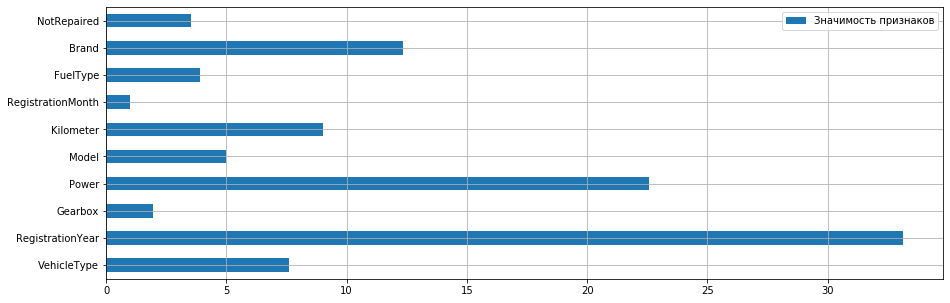

In [25]:
ax = pd.DataFrame(CB.feature_importances_, 
                  columns=['Значимость признаков'], 
                  index=trainX.columns).plot(kind='barh', grid=True, figsize=(15,5))

### LightGBM

In [26]:
%%time 
lgb_train = lgb.Dataset(trainX, trainY)
lgb_test = lgb.Dataset(testX, testY, reference=lgb_train)
parameters = {'metric': 'rmse', 
              'max_depth': 6,
              'random_state': 12345,
              'learning_rate': 0.1}

LG = lgb.train(parameters,
               lgb_train,
               num_boost_round=200,
               valid_sets=[lgb_train, lgb_test],                  
               verbose_eval=10)

[10]	training's rmse: 2555.3	valid_1's rmse: 2548.68
[20]	training's rmse: 1930.74	valid_1's rmse: 1932.34
[30]	training's rmse: 1738.68	valid_1's rmse: 1746.12
[40]	training's rmse: 1668.77	valid_1's rmse: 1681.61
[50]	training's rmse: 1635.29	valid_1's rmse: 1653.83
[60]	training's rmse: 1615.41	valid_1's rmse: 1637.53
[70]	training's rmse: 1599.11	valid_1's rmse: 1625.24
[80]	training's rmse: 1584.08	valid_1's rmse: 1614.6
[90]	training's rmse: 1573.37	valid_1's rmse: 1607.77
[100]	training's rmse: 1563.96	valid_1's rmse: 1601.55
[110]	training's rmse: 1556.63	valid_1's rmse: 1596.22
[120]	training's rmse: 1548.62	valid_1's rmse: 1591.51
[130]	training's rmse: 1541.51	valid_1's rmse: 1586.93
[140]	training's rmse: 1533.63	valid_1's rmse: 1581.92
[150]	training's rmse: 1527.04	valid_1's rmse: 1577.85
[160]	training's rmse: 1521.08	valid_1's rmse: 1573.73
[170]	training's rmse: 1515.51	valid_1's rmse: 1570.64
[180]	training's rmse: 1509.64	valid_1's rmse: 1567.18
[190]	training's rmse

In [27]:
rmse_report(LG, trainX, trainY, testX, testY)

RMSE на тренировочной выборке: 1500.01
RMSE  на   тестовой  выборке: 1561.94


### RandomForest

In [28]:
trainX_ohe, testX_ohe, \
trainY_ohe, testY_ohe = train_test_split(
    pd.get_dummies(data.drop('Price',axis = 1), drop_first=True),
    data['Price'],
    test_size = 0.25, random_state = 12345)

In [29]:
%%time 
RF = RandomForestRegressor(random_state=12345,n_estimators=20)
RF.fit(trainX_ohe, trainY_ohe)

CPU times: user 1min 18s, sys: 0 ns, total: 1min 18s
Wall time: 1min 19s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=20,
                      n_jobs=None, oob_score=False, random_state=12345,
                      verbose=0, warm_start=False)

In [30]:
rmse_report(RF, trainX_ohe, trainY_ohe, testX_ohe, testY_ohe)

RMSE на тренировочной выборке: 756.19
RMSE  на   тестовой  выборке: 1571.05


## Анализ моделей

Обучение показало, что модели градиентного бустинга Catboost и LightGBM позволяют позволяю получить схожие результаты, превосходящие по качеству предсказания RandomForest. Кроме этого, RandomForestRegressor очень сильно переобучается.

---
Для сравнения скорости работы подберем гиперпараметры, обеспечивающие сходное качество предсказания, и замерим время обучения и время предсказания для каждой модели:


### Catboost

In [31]:
%%time
CB = CatBoostRegressor(loss_function='RMSE', depth=12, iterations=60, learning_rate=0.3)
ax = CB.fit(Pool(trainX, trainY, cat_features=cat_feat), verbose=False)

CPU times: user 23.4 s, sys: 3.03 s, total: 26.4 s
Wall time: 27.7 s


In [32]:
%%timeit
CB.predict(testX)

93.1 ms ± 2.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [33]:
print('RMSE  на   тестовой  выборке:', round(mean_squared_error(testY, CB.predict(testX))**0.5, 2))

RMSE  на   тестовой  выборке: 1567.36


### LighGBM

In [34]:
%%time
LG = lgb.train({'metric': 'rmse', 
                'max_depth': 16,
                'random_state': 12345,
                'learning_rate': 0.1},
                lgb.Dataset(trainX, trainY),
                num_boost_round=120)

CPU times: user 6.89 s, sys: 17.8 ms, total: 6.91 s
Wall time: 7.07 s


In [35]:
%%timeit
LG.predict(testX)

772 ms ± 40.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
print('RMSE  на   тестовой  выборке:', round(mean_squared_error(testY, LG.predict(testX))**0.5, 2))

RMSE  на   тестовой  выборке: 1574.73


### RandomForest

In [37]:
%%time
RF = RandomForestRegressor(random_state=12345,n_estimators=20)
RF.fit(trainX_ohe, trainY_ohe)

CPU times: user 1min 17s, sys: 0 ns, total: 1min 17s
Wall time: 1min 18s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=20,
                      n_jobs=None, oob_score=False, random_state=12345,
                      verbose=0, warm_start=False)

In [38]:
%%timeit
RF.predict(testX_ohe)

834 ms ± 7.94 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [39]:
print('RMSE  на   тестовой  выборке:', round(mean_squared_error(testY_ohe, RF.predict(testX_ohe))**0.5, 2))

RMSE  на   тестовой  выборке: 1571.05


## Вывод:

- Модель RandomForestRegressor проигрывает по всем параметрам:  
время обучения, время предсказания и качество предсказания.

---
- Модели Catboost и LightGBM позволяют получить сходное качество прогнозирования.
- При одинаковом качестве предсказания Catboost  дольше обучается,  
 но быстрее предсказывает (29сек - 98мсек),  
 по сравнения с LightGBM (7.7сек - 770мсек)
